*In this notebook, we compare several models for the propagation of surface gravity waves over an infinite fluid layer. Specifically, we consider*

- *the spectral model with quadratic nonlinearity (WW2) proposed by [Dommermuth and Yue](https://dx.doi.org/10.1017/s002211208700288x), [West et al.](https://dx.doi.org/10.1029/jc092ic11p11803), and [Craig and Sulem](https://dx.doi.org/10.1006/jcph.1993.1164),*
- *the "rectified" WW2 model proposed by [Duchêne and Melinand](https://arxiv.org/abs/2203.03277).*
- *the quadratic deep-water model proposed by [Akers and Milewski](https://doi.org/10.1137/090758386) and [Cheng, Granero-Belinchón, Shkoller and Milewski](https://dx.doi.org/10.1007/s42286-019-00005-w)*,
- *the quadratic deep-water model proposed by [Matsuno](https://dx.doi.org/10.1103/PhysRevLett.69.609)*.


# Initialization

Import package

In [44]:
using Pkg
Pkg.activate("..")
using WaterWaves1D
import LinearAlgebra.norm

  Activating project at `~/WaterWaves1D.jl`


Define initial data


In [45]:
η(x)=exp.(-x.^2); # Gaussian initial data for the surface deformation.
v(x)=zero(x)      # we set the initial velocity as zero to avoid inconsistencies among different models.
init=Init(η,v); 

# The quadratic spectral model (WW2)

*We investigate here the spectral model with quadratic nonlinearity (WW2) proposed by [Dommermuth and Yue](https://dx.doi.org/10.1017/s002211208700288x), [West et al.](https://dx.doi.org/10.1029/jc092ic11p11803), and [Craig and Sulem](https://dx.doi.org/10.1006/jcph.1993.1164). We show that the model exhibits high-frequency instabilities, unless a suitable regularization is included.*

First experiment with a small number of modes

In [46]:
param_stable = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    ϵ  = 1/4,    # nonlinearity dimensionless parameter
    μ  = Inf,    # inifinite-depth case
    # Numerical parameters
    N  = 2^9,    # number of collocation points
    L  = 2*π,    # half-length of the numerical tank (-L,L)
    T  = 5,      # final time of computation
    dt = 0.001,  # timestep
                );
WW2_stable = Problem( WWn(param_stable,dealias = 1), init, param_stable ) 
solve!(WW2_stable);

┌ Info: Now solving the initial-value problem WW2
│ with timestep dt=0.001, final time T=5.0,
│ and N=512 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Plot solution at final time


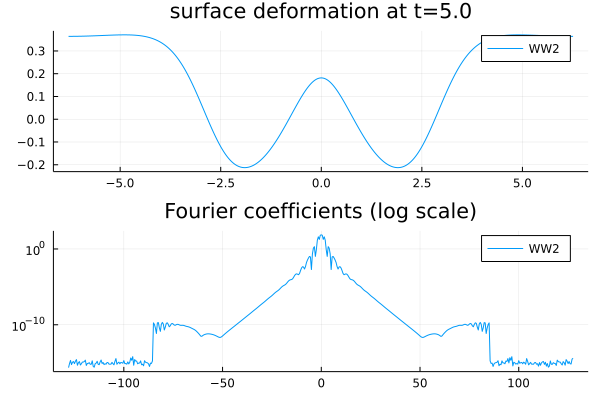

In [47]:
plot_solution(WW2_stable;fourier=true)

Second experiment with more modes

In [48]:
param_unstable = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    ϵ  = 1/4,    # nonlinearity dimensionless parameter
    μ  = Inf,    # inifinite-depth case
    # Numerical parameters
    N  = 2^11,   # number of collocation points
    L  = 2*π,    # half-length of the numerical tank (-L,L)
    T  = 1.5,      # final time of computation
    dt = 0.001,  # timestep
                );
WW2_unstable = Problem( WWn(param_unstable,dealias = 1), init, param_unstable ) 
solve!(WW2_unstable);

┌ Info: Now solving the initial-value problem WW2
│ with timestep dt=0.001, final time T=1.5,
│ and N=2048 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Plot solution just before breakup


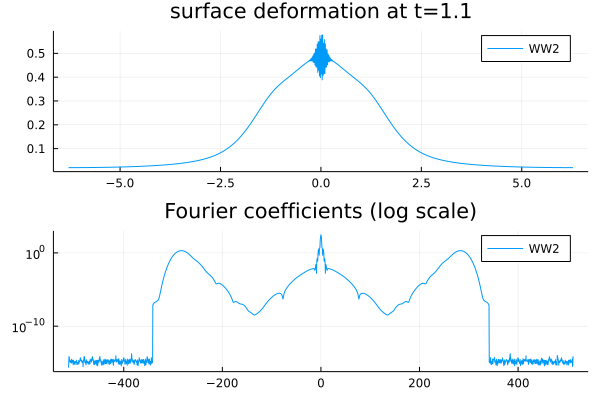

In [49]:
plot_solution(WW2_unstable;t=1.1,fourier=true)

The (very) high-frequency component of the flow, which is generated by machine-precision rounding errors, is rapidly amplified and produces spurious numerical oscillations. This phenomenon is not due to aliasing, since a dealiasing filter (adapted to quadratic nonlinearities) has been used. Although we use an explicit time integrator (RK4) is not due to CFL-type conditions, since it is stable when diminishing the timestep.

# The rectified quadratic spectral model

*We use here the rectified WW2 model introduced by Duchêne and Melinand*

In [50]:
WW2_rectified = Problem( WWn(param_unstable,dealias = 1,δ=0.01), init, param_unstable,label="rWW2" ) # δ is the strength of the regularization
solve!(WW2_rectified);

┌ Info: Now solving the initial-value problem rWW2
│ with timestep dt=0.001, final time T=1.5,
│ and N=2048 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Plot solution at final time


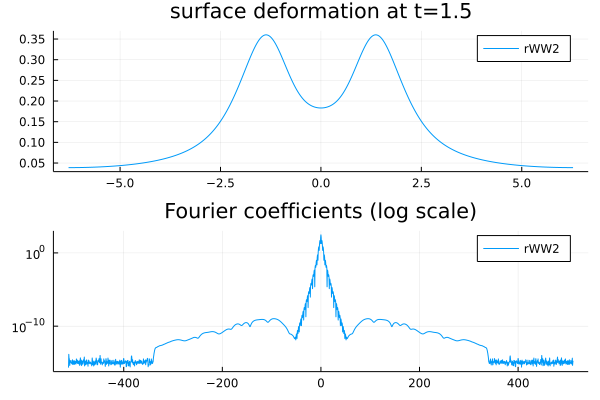

In [51]:
plot_solution(WW2_rectified;fourier=true)

The solution shows no more sign of instabilities. And this is so for much higher number of modes (provided the timestep is sufficiently small).

Plot the difference between the solutions to the rectified and non-rectified WW2 models.

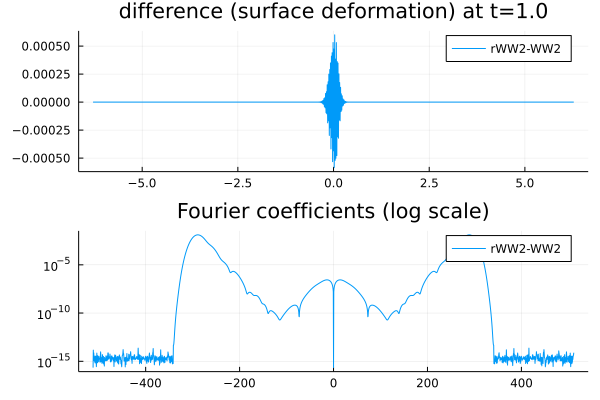

In [52]:
plot_difference((WW2_rectified,WW2_unstable),t=1,fourier=true)

By plotting the difference, we see that the rectification suppresses high-frequency instabilities without affecting the main profile of the wave determined by small wavenumbers.

# Disintegration of a heap of water

*We now compare*
- *the "rectified" WW2 model,*
- *the quadratic deep-water model proposed by [Akers and Milewski](https://doi.org/10.1137/090758386) and [Cheng, Granero-Belinchón, Shkoller and Milewski](https://dx.doi.org/10.1007/s42286-019-00005-w)*,
- *the quadratic deep-water model proposed by [Matsuno](https://dx.doi.org/10.1103/PhysRevLett.69.609)*,

*with the "exact" water waves equation,
with an initial data consisting of an excess of mass, with zero initial velocity*.

In [53]:
param_heap = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    ϵ  = 1/4,    # nonlinearity dimensionless parameter
    μ  = Inf,    # infinite-depth case
    # Numerical parameters
    N  = 2^9,   # number of collocation points
    L  = 2*π,    # half-length of the numerical tank (-L,L)
    T  = 5,      # final time of computation
    dt = 0.001,  # timestep
)
init=Init(x->exp.(-x.^2),x->zero(x)); 
WW_heap = Problem( WaterWaves(param_heap,dealias = 1, verbose=false), init, param_heap );
rWW2_heap = Problem( WWn(param_heap,dealias = 1, δ=0.02), init, param_heap, label="rWW2" ) # δ is the strength of the regularization
Matsuno_heap = Problem( Matsuno(param_heap,dealias = 1), init, param_heap )
AkersNicholls_heap = Problem( AkersNicholls(param_heap,dealias = 1), init, param_heap )

solve!(WW_heap);solve!(rWW2_heap);solve!(Matsuno_heap);solve!(AkersNicholls_heap);

┌ Info: Now solving the initial-value problem water waves
│ with timestep dt=0.001, final time T=5.0,
│ and N=512 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
┌ Info: Now solving the initial-value problem rWW2
│ with timestep dt=0.001, final time T=5.0,
│ and N=512 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: Now solving the initial-value problem Matsuno
│ with timestep dt=0.001, final time T=5.0,
│ and N=512 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
┌ Info: Now solving the initial-value problem Akers-Nicholls
│ with timestep dt=0.001, final time T=5.0,
│ and N=512 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Prog

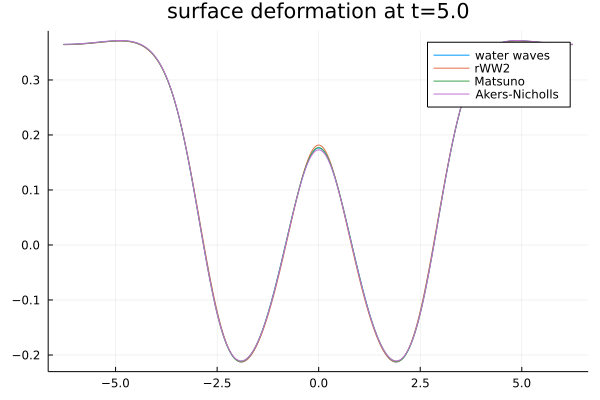

In [54]:
plot_solution([WW_heap,rWW2_heap,Matsuno_heap,AkersNicholls_heap],fourier=false)

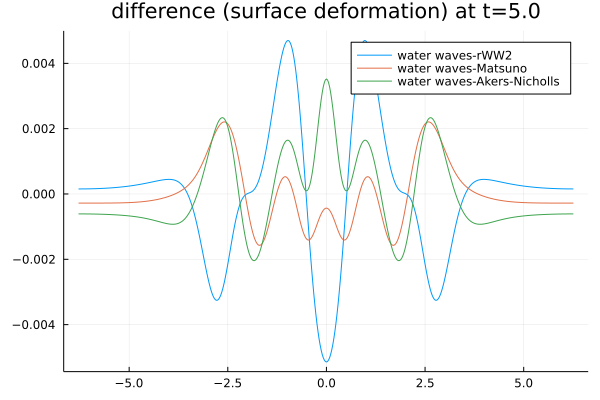

Errors (in l²). rectified WW2: 0.0020087637370018166, Matsuno: 0.0009186726516688678, Akers&Nicholls: 0.001220380649377664

In [55]:
plt=plot_difference(([WW_heap,rWW2_heap],[WW_heap,Matsuno_heap],[WW_heap,AkersNicholls_heap]);fourier=false)
display(plt)
WWη,WWv,WWx,=solution(WW_heap)
rWW2η,=solution(rWW2_heap,x=WWx);errWW2=norm(WWη-rWW2η)/sqrt(length(WWx))
Matη,=solution(Matsuno_heap,x=WWx);errMat=norm(WWη-Matη)/sqrt(length(WWx))
ANη,=solution(AkersNicholls_heap,x=WWx);errAN=norm(WWη-ANη)/sqrt(length(WWx))

print("Errors (in l²). rectified WW2: $errWW2, Matsuno: $errMat, Akers&Nicholls: $errAN")

# Random initial data

*We now compare*
- *the "rectified" WW2 model,*
- *the quadratic deep-water model proposed by [Akers and Milewski](https://doi.org/10.1137/090758386) and [Cheng, Granero-Belinchón, Shkoller and Milewski](https://dx.doi.org/10.1007/s42286-019-00005-w)*,
- *the quadratic deep-water model proposed by [Matsuno](https://dx.doi.org/10.1103/PhysRevLett.69.609)*,

*with the "exact" water waves equation,
with an initial data consisting of a random initial surface perturbation, with zero initial velocity*.

In [56]:
param_rand = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    ϵ  = 1/4,    # nonlinearity dimensionless parameter
    μ  = Inf,    # infinite-depth case
    # Numerical parameters
    N  = 2^10,   # number of collocation points
    L  = 2*π,    # half-length of the numerical tank (-L,L)
    T  = 1,      # final time of computation
    dt = 0.001,  # timestep
)
mesh=Mesh(param_rand);x=mesh.x;
init= Random(x;L=2,a=(1,0)); # we set the initial velocity as zero to avoid possible inconsistencies among different models.
WW_rand = Problem( WaterWaves(param_rand,dealias = 1, verbose=false), init, param_rand );
rWW2_rand = Problem( WWn(param_rand,dealias = 1, δ=0.05), init, param_rand, label="rWW2" );
Matsuno_rand = Problem( Matsuno(param_rand,dealias = 1), init, param_rand );
AkersNicholls_rand = Problem( AkersNicholls(param_rand,dealias = 1), init, param_rand );

solve!(WW_rand);solve!(rWW2_rand);solve!(Matsuno_rand);solve!(AkersNicholls_rand);

┌ Info: Now solving the initial-value problem water waves
│ with timestep dt=0.001, final time T=1.0,
│ and N=1024 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Info: Now solving the initial-value problem rWW2
│ with timestep dt=0.001, final time T=1.0,
│ and N=1024 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Now solving the initial-value problem Matsuno
│ with timestep dt=0.001, final time T=1.0,
│ and N=1024 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Now solving the initial-value problem Akers-Nicholls
│ with timestep dt=0.001, final time T=1.0,
│ and N=1024 collocation points.
└ @ WaterWaves1D /home/user/WaterWaves1D.jl/src/problem.jl:123


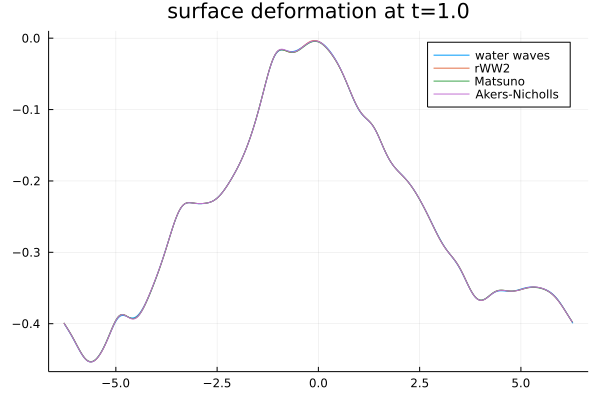

In [57]:
plot_solution([WW_rand,rWW2_rand,Matsuno_rand,AkersNicholls_rand],fourier=false)

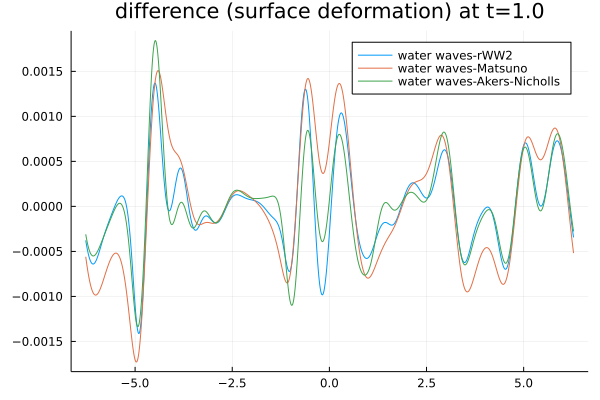

Errors (in l²). rectified WW2: 0.00048564774363374846, Matsuno: 0.0006896378803682378, Akers&Nicholls: 0.0004985995294864523

In [58]:
plt=plot_difference(([WW_rand,rWW2_rand],[WW_rand,Matsuno_rand],[WW_rand,AkersNicholls_rand]);fourier=false)
display(plt)
WWη,WWv,WWx,=solution(WW_rand)
rWW2η,=solution(rWW2_rand,x=WWx);errWW2=norm(WWη-rWW2η)/sqrt(length(WWx))
Matη,=solution(Matsuno_rand,x=WWx);errMat=norm(WWη-Matη)/sqrt(length(WWx))
ANη,=solution(AkersNicholls_rand,x=WWx);errAN=norm(WWη-ANη)/sqrt(length(WWx))

print("Errors (in l²). rectified WW2: $errWW2, Matsuno: $errMat, Akers&Nicholls: $errAN")